In [1]:
import sys
import os
import neo
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import seaborn as sns
import elephant as el
import quantities as pq
sns.set(style='ticks', palette='bright', context='talk')

In [2]:
neo.__version__ # to 0.5b

'0.5.1'

## Load data with neo IO

In [3]:
filename = os.path.expanduser('~') + '/Sciebo/Data/WaveScalES/IDIBAPS/161101_rec07_Spontaneous_RH.smr'
neo_obj = neo.io.spike2io.Spike2IO(filename)

In [4]:
segment = neo_obj.read_segment()

## Annotate the analogsignals with metadata

In [5]:
electrode_location = {'Visual Cortex' : [18,19,20,22,23,24,25,27,28,29,30,31,32],
                      'Retrospenial Cortex' : [13,17,21,26],
                      'Parietal Association Cortex' : [14,15,16],
                      'Somatosensory Cortex' : [4,5,7,8,10,11,12],
                      'Motor Cortex' : [1,2,3,6,9]
                     }

electrode_color = {'Visual Cortex' : '#0C6BB1',
                   'Retrospenial Cortex' : '#422F58',
                   'Parietal Association Cortex' : '#01B24E',
                   'Somatosensory Cortex' : '#F92600',
                   'Motor Cortex' : '#EF6700'
                     }

for asig in segment.analogsignals:
    for element in electrode_location:
        if asig.annotations['physical_channel_index']+1 in electrode_location[element]:
            asig.annotations['cortical_location'] = element
            
# ToDo: Annotate with x and y position

## Plot signal traces

In [6]:
asig = segment.analogsignals[0] 
num_sampling_points = (asig.t_stop.rescale('s') - asig.t_start.rescale('s')) \
                    * asig.sampling_rate.rescale('1/s')
sampling_times = np.linspace(asig.t_start, asig.t_stop, num_sampling_points)

/home/rgutzen/anaconda3/envs/wavescale/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'quantities.quantity.Quantity'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


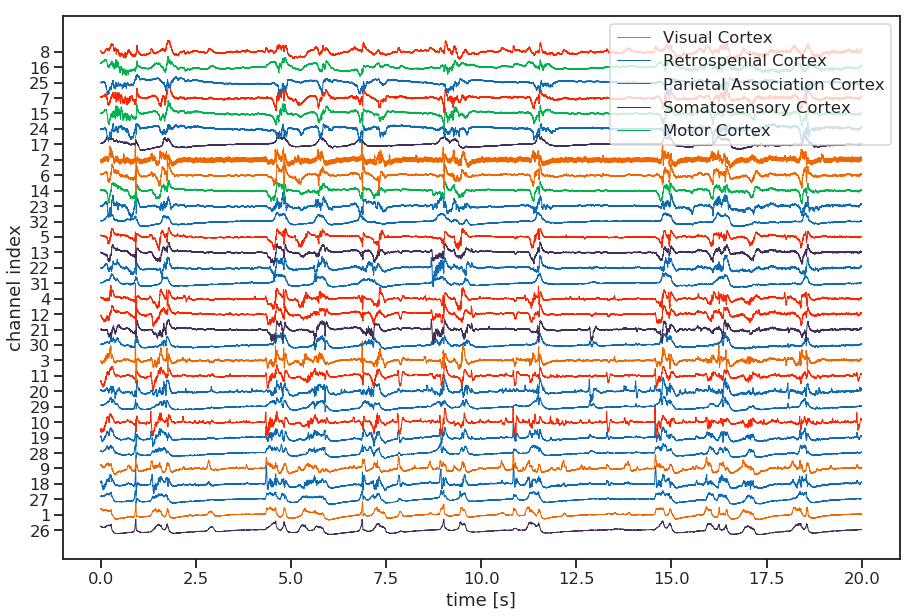

In [7]:
time_window = (0,20)  # in seconds [0,304]

fig, ax = plt.subplots(figsize=(15,10))
idx = [int(time_in_s * asig.sampling_rate.rescale('1/s').magnitude) for time_in_s in time_window]
scaling = 6
handles = []
for asig_count, asig in enumerate(segment.analogsignals):
    handle,  = ax.plot(sampling_times[idx[0]:idx[1]], 
               sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]) + asig_count*scaling,
               linewidth=1, color=electrode_color[asig.annotations['cortical_location']],
               label=asig.annotations['cortical_location'])
    if asig.annotations['physical_channel_index']+1 \
       in [electrode_location[key][0] for key in electrode_location.keys()]:
        handles += [handle]
    
ax.set_yticks(np.arange(len(segment.analogsignals))*scaling)
ax.set_yticklabels([asig.annotations['physical_channel_index']+1 for asig in segment.analogsignals])
ax.set_ylabel('channel index')
ax.set_xlabel('time [s]')
plt.legend(handles, electrode_location.keys(), loc=1)

## Plot power spectrum

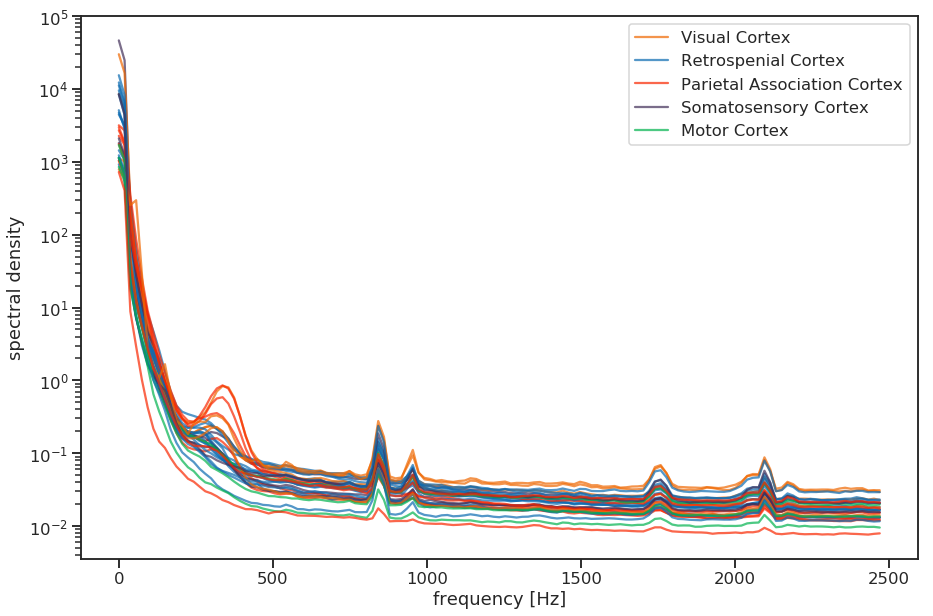

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
handles = []
for asig_count, asig in enumerate(segment.analogsignals):
    (p1, f1) = psd(np.squeeze(asig.magnitude), NFFT=265, Fs=asig.sampling_rate.rescale('Hz'))
    handle, = ax.semilogy(f1, p1, alpha=0.7, 
                          color=electrode_color[asig.annotations['cortical_location']])
    if asig.annotations['physical_channel_index']+1 \
       in [electrode_location[key][0] for key in electrode_location.keys()]:
        handles += [handle]
ax.set_ylabel('spectral density')
ax.set_xlabel('frequency [Hz]')
plt.legend(handles, electrode_location.keys(), loc=1)

In [9]:
asig.sampling_rate.rescale('Hz')

array(4960.31746032) * Hz

## Lowpass signal (<1000 Hz)

In [13]:
analogsignals_lowpass = [el.signal_processing.butter(asig, highpass_freq=None, lowpass_freq=1000*pq.Hz, 
                         order=4, filter_function='filtfilt', fs=1.0, axis=-1) for asig in segment.analogsignals]

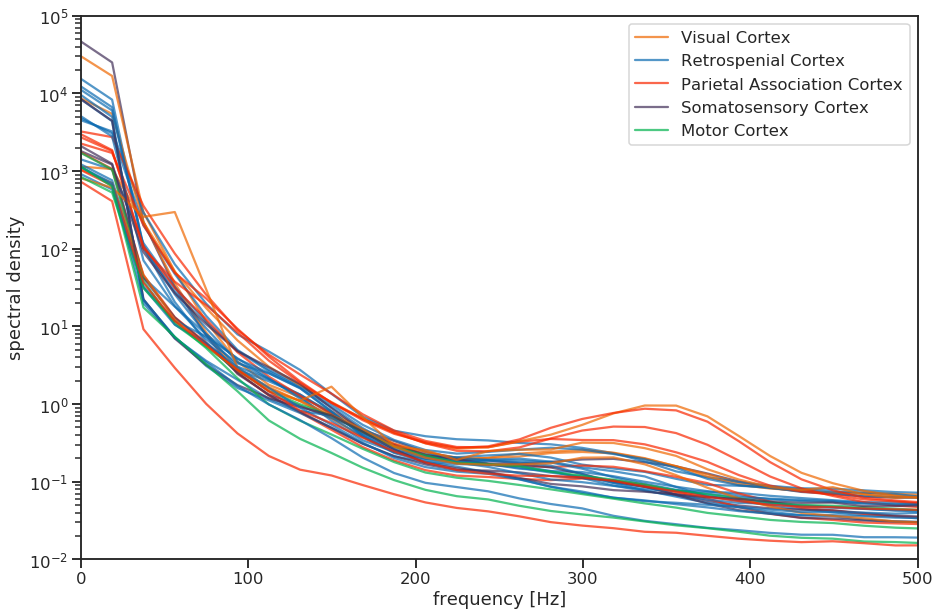

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
handles = []
for asig_count, asig in enumerate(analogsignals_lowpass):
    (p1, f1) = psd(np.squeeze(asig.magnitude), NFFT=265, noverlap=50, 
                   Fs=asig.sampling_rate.rescale('Hz'))
    handle, = ax.semilogy(f1, p1, alpha=0.7, 
                          color=electrode_color[asig.annotations['cortical_location']])
    if asig.annotations['physical_channel_index']+1 \
       in [electrode_location[key][0] for key in electrode_location.keys()]:
        handles += [handle]
ax.set_xlim((0,500))
ax.set_ylim((10**(-2),10**(5)))
ax.set_ylabel('spectral density')
ax.set_xlabel('frequency [Hz]')
plt.legend(handles, electrode_location.keys(), loc=1)

## Distribution of signal amplitudes

In [21]:
# sig = np.concatenate([asig for asig in sc.stats.zscore(segment.analogsignals)])

<BarContainer object of 200 artists>

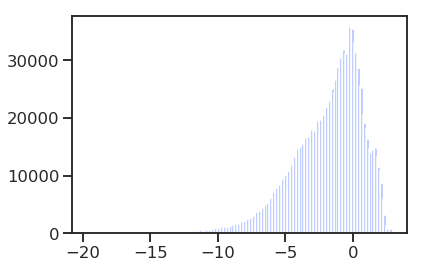

In [36]:
asig = sc.stats.zscore(segment.analogsignals[0])
amplitudes = np.squeeze(asig)**2

hist, edges = np.histogram(amplitudes, bins=200)
plt.bar(edges[:-1]+np.diff(edges)/2., hist, width=np.diff(edges))
# plt.yscale('log')

In [16]:
# log asig^2, zscore?, hilbert?

array([[ 53.253174],
       [ 44.708252],
       [ 43.640137],
       ...,
       [-11.749268],
       [-12.664795],
       [-11.901855]], dtype=float32)